In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report
import os
from transformers import Trainer, TrainingArguments
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import pandas as pd
label_map = {
    'affected_individuals': 0,
    'infrastructure_and_utility_damage': 1,
    'not_humanitarian': 2,
    'other_relevant_information': 3,
    'rescue_volunteering_or_donation_effort': 4,
    'vehicle_damage': 1,
    'injured_or_dead_people': 0,
    'missing_or_found_people': 0
}

In [2]:
class NPZLoader(Dataset):
    def __init__(self, img_embed_filename,text_emb_filename,tsv_file, transform=None):
#        self.files = list(Path(path).glob('*/*.npz'))
#        self.transform = transform
        self.text_embed = torch.load(text_embed_filename).mean(axis=1) # ../sporwal9/eng_test_data_emb.pt
        self.img_emb = np.load(img_embed_filename) #image_model_ouputs/resnet18_image_embedding_512_test.npz
        self.original_df = pd.read_csv(tsv_file, sep='\t') #'../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv'
        self.df = self.original_df.loc[original_df.label_text_image=="Positive"]
        id_list=  list(self.df['tweet_id'].unique())
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_tweetID = self.img_emb['image_tweetID'][idx]
        
        image_embedding = torch.from_numpy(self.img_emb['image_embedding'][idx].squeeze(1))
        
        text_embedding = self.text_embed[idx].unsqueeze(1)
        fusion_emb = torch.cat((text_embedding.cuda(),image_embedding.cuda()),dim=0)
        label = self.df.loc[self.df['tweet_id']==image_tweetID,'label'][0]
        if image_tweetID in id_list :
            return fusion_emb,image_tweetID,label


In [3]:
def AlignFormatLabels(list, labels):
    aligned_list = []
    for item in list:
        if item == 'vehicle_damage':
            aligned_list.append('infrastructure_and_utility_damage')
        elif item == 'missing_or_found_people' or item == 'injured_or_dead_people':
            aligned_list.append('affected_individuals')
        else:
            aligned_list.append(item)
    final_labels = []
    for item in aligned_list:
        final_labels.append(labels.index(item))
    return final_labels

my_labels = ['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
             'infrastructure_and_utility_damage', 'not_humanitarian']

## Pre-processing

In [4]:
test_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_test.tsv'
train_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv'
val_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_dev.tsv'

df_test = pd.read_csv(test_tsv_file, sep='\t')
df_train = pd.read_csv(train_tsv_file, sep='\t')
df_val = pd.read_csv(val_tsv_file, sep='\t')

df_train.shape, df_test.shape, df_val.shape

((13608, 9), (2237, 9), (2237, 9))

In [5]:
df_train.head(2)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative


In [6]:
# get training labels in right format
raw_train_labels = df_train[df_train.label_text_image == "Positive"]["label_text"]
train_labels = torch.Tensor(AlignFormatLabels(raw_train_labels, my_labels))

# get testing labels in right format
raw_test_labels = df_test[df_test.label_text_image == "Positive"]["label_text"]
test_labels = torch.Tensor(AlignFormatLabels(raw_test_labels, my_labels))

train_labels.to("cuda")
test_labels.to("cuda")

print(len(test_labels), len(train_labels))

955 6126


In [7]:
positive_ids_train = df_train.loc[df_train.label_text_image=="Positive"].index

In [10]:
text_emb_test_raw = torch.load('../sporwal9/hindi_test_data_emb.pt')
text_emb_train_raw = torch.load('../sporwal9/hindi_train_data_emb.pt')
# text_emb_val_raw = torch.load('../sporwal9/eng_dev_data_emb.pt')

In [11]:
text_emb_test = text_emb_test_raw.mean(axis=1).squeeze(1)
text_emb_train = text_emb_train_raw.mean(axis=1).squeeze(1)
# text_emb_val = text_emb_val_raw.mean(axis=1).squeeze(1)

In [12]:
text_emb_test.shape, text_emb_train.shape

(torch.Size([955, 256]), torch.Size([6126, 256]))

In [13]:
img_emb_test_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_test.npz")
img_emb_train_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_train.npz")
# img_emb_val_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_dev.npz")

In [14]:
img_emb_test, img_tweetID_test = img_emb_test_raw['image_embedding'], img_emb_test_raw['image_tweetID']
img_emb_train, img_tweetID_train = img_emb_train_raw['image_embedding'], img_emb_train_raw['image_tweetID']
# img_emb_val, img_tweetID_val = img_emb_val_raw['image_embedding'], img_emb_val_raw['image_tweetID']

img_emb_test = torch.from_numpy(img_emb_test[0:955]).squeeze((2,3))
img_emb_train = torch.from_numpy(img_emb_train[0:13608]).squeeze((2,3))
# img_emb_val = torch.from_numpy(img_emb_val).squeeze((2,3))

img_emb_train = img_emb_train[positive_ids_train]

In [15]:
img_emb_test.shape, img_emb_train.shape

(torch.Size([955, 512]), torch.Size([6126, 512]))

In [16]:
img_tweetID_test.shape, img_tweetID_train.shape

((955,), (13608,))

In [17]:
X_train = torch.cat((text_emb_train.cuda(), img_emb_train.cuda()), dim=1)
X_test = torch.cat((text_emb_test.cuda(), img_emb_test.cuda()), dim=1)

# train_dataset = DatasetFormatting(X_train, train_labels)
# test_dataset = DatasetFormatting(X_test, test_labels)

In [18]:
X_train.shape, X_test.shape

(torch.Size([6126, 768]), torch.Size([955, 768]))

## Multimodal Network

In [24]:
in_features = 600
h1 = 512
h2 = 128
h3 = 32
out_features = 5

print(in_features, h1, h2, h3, out_features)

600 512 128 32 5


In [41]:
class Multimodal(torch.nn.Module):
    def __init__(self, dropout = 0.1):
        super().__init__()
        self.multimodal = torch.nn.Sequential(
            # input layer
            torch.nn.Linear(X_train.shape[1], in_features),
            # dropout
            torch.nn.Dropout(dropout),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer1
            torch.nn.Linear(in_features, h1),
            # dropout
            torch.nn.Dropout(dropout),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer2
            torch.nn.Linear(h1, h2),
            # dropout
            torch.nn.Dropout(dropout),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer3
            torch.nn.Linear(h2, h3),
            # dropout
            torch.nn.Dropout(dropout),
            # ReLU activation
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(h3, out_features),
            # dropout
            torch.nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.multimodal(x)
    
multimodal = Multimodal(dropout=0)
multimodal.to("cuda")

Multimodal(
  (multimodal): Sequential(
    (0): Linear(in_features=768, out_features=600, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=512, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): Dropout(p=0, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): Dropout(p=0, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=5, bias=True)
    (13): Dropout(p=0, inplace=False)
  )
)

In [42]:
EPOCHS = 10
batch_size = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multimodal.parameters(), lr=0.01)

In [43]:
losses = []

for epoch in range(EPOCHS):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = multimodal(Xbatch).type(torch.float64).to("cuda")
        ybatch = train_labels[i:i+batch_size].type(torch.LongTensor).to("cuda")
        loss = criterion(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach().numpy())
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 1.1908745443180502
Finished epoch 1, latest loss 1.2009073891087094
Finished epoch 2, latest loss 1.1821755265571174
Finished epoch 3, latest loss 1.14221614933916
Finished epoch 4, latest loss 1.1807659710167397
Finished epoch 5, latest loss 1.1188481698875992
Finished epoch 6, latest loss 1.083681136043518
Finished epoch 7, latest loss 0.9885141687455621
Finished epoch 8, latest loss 0.9193524472064151
Finished epoch 9, latest loss 0.9226230566882219


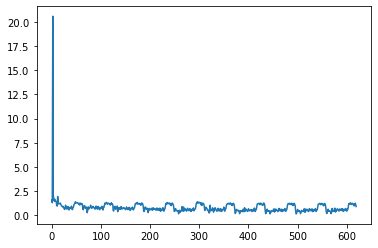

In [44]:
plt.plot(losses)

In [45]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred_train = multimodal(X_train).argmax(axis=1)
accuracy = (y_pred_train == train_labels.to("cuda")).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.7466536164283752


In [46]:
target_names=['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
              'infrastructure_and_utility_damage', 'not_humanitarian']
print(classification_report(train_labels, y_pred_train.cpu(), target_names=target_names))

                                        precision    recall  f1-score   support

            other_relevant_information       0.84      0.61      0.71      1279
                  affected_individuals       0.00      0.00      0.00        71
rescue_volunteering_or_donation_effort       0.55      0.66      0.60       912
     infrastructure_and_utility_damage       0.00      0.00      0.00       612
                      not_humanitarian       0.78      0.98      0.87      3252

                              accuracy                           0.75      6126
                             macro avg       0.43      0.45      0.44      6126
                          weighted avg       0.67      0.75      0.70      6126



/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [47]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = multimodal(X_test).argmax(axis=1)
accuracy = (y_pred == test_labels.to("cuda")).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.39790576696395874


In [48]:
target_names=['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
              'infrastructure_and_utility_damage', 'not_humanitarian']
print(classification_report(test_labels, y_pred.cpu(), target_names=target_names))

                                        precision    recall  f1-score   support

            other_relevant_information       0.45      0.84      0.58       235
                  affected_individuals       0.00      0.00      0.00         9
rescue_volunteering_or_donation_effort       0.01      0.02      0.02       126
     infrastructure_and_utility_damage       0.00      0.00      0.00        81
                      not_humanitarian       0.59      0.36      0.44       504

                              accuracy                           0.40       955
                             macro avg       0.21      0.24      0.21       955
                          weighted avg       0.42      0.40      0.38       955



/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi